In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib import colors

import xarray

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


In [2]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from ALLCools.plot.color import plot_colorbar
from ALLCools.plot.utilities import tight_hue_range


def sunbrust(pie_data, ax,
             hue=None, hue_portion=0.5,
             cmap='viridis', colorbar=True,
             colorbar_kws=None,
             inner_radius=0.25, outer_radius=1,
             anno_col=None, text_anno='text', anno_layer_size=0.05,
             col_color_dict=None, startangle=0, anno_ang_min=5,
             anno_border=1.2, text_expend=1.05,
             anno_colors=None, anno_layer_gap=0.02,
             uniform_section=False, order_dict=None):
    """
    Parameters
    ----------
    pie_data
        Tidy dataframe
    ax
    hue
    hue_portion
    cmap
    colorbar
    colorbar_kws
    inner_radius
    outer_radius
    anno_col
    text_anno
    anno_layer_size
    col_color_dict
    startangle
    anno_ang_min
    anno_border
    text_expend
    uniform_section
    order_dict

    Returns
    -------

    """
    return_axes = [ax]
    if order_dict is None:
        order_dict = {}

    # prepare hue colormap
    if hue is not None:
        if isinstance(hue, str):
            hue_data = pie_data.pop(hue)
        elif isinstance(hue, pd.Series):
            hue_data = hue
        else:
            hue_data = pd.Series(hue, index=pie_data.index)
        if not isinstance(cmap, colors.Colormap):
            cmap = plt.get_cmap(cmap)
        cmap.set_bad('gray')

        vmin, vmax = tight_hue_range(hue_data, hue_portion)
        norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        col_color_dict = {}
        for col_name, col in pie_data.iteritems():
            reduce_col_data = hue_data.groupby(col).mean()
            col_color_dict[col_name] = {k: mapper.to_rgba(v)
                                        for k, v in reduce_col_data.iteritems()}

        # make colorbar
        if colorbar:
            _colorbar_kws = {'labelsize': 4,
                             'linewidth': 0.5,
                             'orientation': 'vertical'}
            if colorbar_kws is None:
                colorbar_kws = {}
            _colorbar_kws.update(colorbar_kws)
            bbox_to_anchor = _colorbar_kws.pop('bbox_to_anchor')

            cax = inset_axes(ax, width="3%", height="25%",
                             loc='lower right', borderpad=0,
                             bbox_to_anchor=bbox_to_anchor)
            cax = plot_colorbar(cax, cmap=cmap, cnorm=norm, hue_norm=(vmin, vmax),
                                label=hue_data.name, **_colorbar_kws)
            return_axes.append(cax)

    # prepare data
    if uniform_section:
        dedup_groups = pie_data.reset_index().set_index(pie_data.columns.tolist()).index.drop_duplicates()
        dedup_groups = pd.DataFrame(dedup_groups.tolist(), columns=pie_data.columns)
        pie_data = dedup_groups

    # prepare color
    _col_color_dict = {col: None for col in pie_data.columns}
    if col_color_dict is not None:
        _col_color_dict.update(col_color_dict)

    # prepare plot parameters
    ncols = pie_data.columns.size
    if anno_col is None:
        anno_layer_size = 0
        anno_layer_gap = 0
    outer_radius = outer_radius - anno_layer_size - anno_layer_gap
    layer_size = (outer_radius - inner_radius) / ncols

    # plot multiple donuts
    previous_order = pd.Series([])
    anno_wedges = []
    anno_names = []
    for col, col_name in enumerate(pie_data.columns):
        cur_radius = inner_radius + (col + 1) * layer_size
        col_pie_data = pie_data[col_name].value_counts()

        # manage order
        if col_name in order_dict:
            _ordered_data = col_pie_data.reindex(pd.Index(order_dict[col_name]))
            previous_order = _ordered_data
        else:
            if col == 0:
                _ordered_data = col_pie_data
                previous_order = _ordered_data
            else:
                records = []
                for section in previous_order.index:
                    section_subs = pie_data[pie_data.iloc[:, col - 1] == section][col_name].unique()
                    records.append(col_pie_data.reindex(pd.Index(section_subs)).sort_values(ascending=False))
                _ordered_data = pd.concat(records)
                previous_order = _ordered_data

        # plot the real pie charts
        pie_color = _col_color_dict[col_name]
        if isinstance(pie_color, dict):
            pie_color = [pie_color[i] for i in _ordered_data.index]
        ax.pie(_ordered_data, radius=cur_radius,
               colors=pie_color, startangle=startangle,
               wedgeprops=dict(width=layer_size, linewidth=pie_linewidth, edgecolor='w'))

        # plot an additional thin layer to anchor anno label
        if anno_col == col:
            if anno_colors is not None:
                _color = [anno_colors[i] for i in order_dict[col_name]]
                
            else:
                _color = pie_color
            
            wedges, texts = ax.pie(_ordered_data, radius=outer_radius + anno_layer_gap + anno_layer_size,
                                   colors=_color, startangle=startangle,
                                   wedgeprops=dict(width=anno_layer_size, linewidth=pie_linewidth, edgecolor='w'))
            if text_anno:
                anno_wedges = wedges
                anno_names = _ordered_data.index.tolist()

    # annotate wedges
    for i, p in enumerate(anno_wedges):
        delta_ang = p.theta2 - p.theta1
        if delta_ang < anno_ang_min:
            continue
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        if text_anno == 'anno_box':
            # wedges annotation
            bbox_props = dict(boxstyle="round,pad=0.2", fc="#FFFFFF88", ec="#00000022", lw=0.72)
            kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-", color='#00000055'),
                      bbox=bbox_props, zorder=0, va="center")
            # separate all y
            y_niche = np.arange(-anno_border, anno_border, anno_border / 10)
            allow_y_niche = OrderedDict(enumerate(y_niche))

            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang},rad=5"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})

            suitable_niche = np.abs(np.array(list(allow_y_niche.values())) - anno_border * y).argmin()
            suitable_niche = list(allow_y_niche.keys())[suitable_niche]
            y_niche = allow_y_niche.pop(suitable_niche)
            ax.annotate(anno_names[i], xy=(x, y), xytext=(anno_border * np.sign(x), y_niche),
                        horizontalalignment=horizontalalignment, **kw)
        elif text_anno == 'text':
            ha = 'left'
            if x < 0:
                # left side label
                ang += 180
                ha = 'right'
            if ang > 180:
                # so label will not be up-side-down
                ang = ang - 360
            ax.text(x * text_expend, y * text_expend, anno_names[i],
                    fontdict=None, withdash=False,
                    rotation=ang, va='center', ha=ha,
                    rotation_mode='anchor')
        elif text_anno is None:
            pass
        else:
            raise ValueError(f'text_anno can only be "text", "anno_box" or None, got {text_anno}')

    if len(return_axes) == 1:
        return ax
    else:
        return tuple(return_axes)


In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
predict_results = pd.read_msgpack('total_prediction_summary.msg')

In [11]:
ratio_dict = {}
cell_tidy_data['RegionCorrect'] = predict_results['soft1']
ratio_dict['SubType'] = cell_tidy_data.groupby('SubType').apply(
    lambda i: i['RegionCorrect'].sum() / i.shape[0])

cell_tidy_data['RegionCorrect'] = predict_results['soft1']
ratio_dict['MajorType'] = cell_tidy_data.groupby('MajorType').apply(
    lambda i: i['RegionCorrect'].sum() / i.shape[0])

cell_tidy_data['RegionCorrect'] = predict_results['soft1']
ratio_dict['CellClass'] = cell_tidy_data.groupby('CellClass').apply(
    lambda i: i['RegionCorrect'].sum() / i.shape[0])


In [12]:
region_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
sub_region_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
major_region_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
cell_class_order = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/order/CellClass.order.txt',
    index_col=0,
    header=None,
    sep='\t').index
major_type_order = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/order/MajorType-Copy1.order_by_l1_analysis_and_name.txt',
    index_col=0,
    header=None,
    sep='\t').index

cell_class_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
major_type_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
sub_type_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'
        


In [13]:
from matplotlib import rc

labelsize = 6
linewidth = 0.1
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)

In [21]:
cell_class_order = ['Exc', 'Inh']
major_type_order = ['IT-L23', 'IT-L4', 'IT-L5', 'IT-L6', 'CLA', 'EP', 'OLF-Exc', 'PT-L5',
       'CT-L6', 'NP-L6', 'L6b', 'CA1', 'IG-CA2', 'CA3', 'CA3-St18', 'Gfra1',
       'DG-po', 'DG', 'MGE-Pvalb', 'MGE-Sst', 'CGE-Vip', 'CGE-Lamp5', 'Unc5c',
       'Chd7', 'LSX-Inh', 'PAL-Inh', 'Foxp2', 'MSN-D1', 'MSN-D2', 'D1L-Fstl4',
       'D1L-PAL', 'OLF']

## Color By Gene

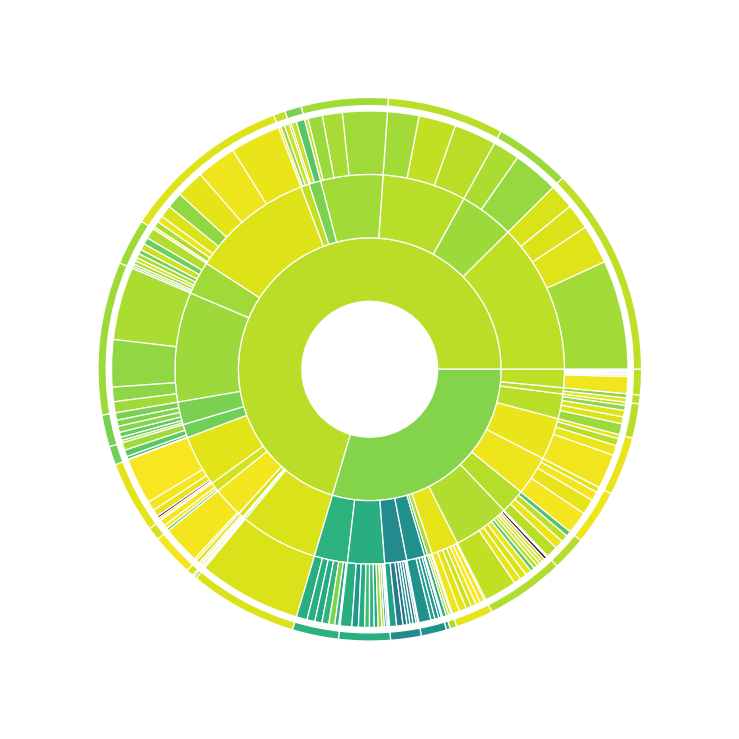

In [29]:
pie_linewidth = 0.3

palette = 'viridis'
vmin = 0.
vmax = 1.


cmap = plt.get_cmap(palette)
cmap.set_bad('gray')
norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

col_color_dict = {} 
col_color_dict['CellClass'] = {
    k: mapper.to_rgba(v)
    for k, v in ratio_dict['CellClass'].iteritems()
}
col_color_dict['MajorType'] = {
    k: mapper.to_rgba(v)
    for k, v in ratio_dict['MajorType'].iteritems()
}
col_color_dict['SubType'] = {
    k: mapper.to_rgba(v)
    for k, v in ratio_dict['SubType'].iteritems()
}


fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
_cell_tidy_data = cell_tidy_data[['CellClass', 'MajorType', 'SubType']].copy()

sunbrust(pie_data=_cell_tidy_data.loc[_cell_tidy_data['CellClass'] != 'NonN'],
         order_dict={
             'CellClass': cell_class_order,
             'MajorType': major_type_order
         },
         ax=ax,
         anno_col=1,
         text_anno=False,
         anno_layer_size=0.03,
         col_color_dict=col_color_dict,
         startangle=0,
         anno_ang_min=0.001,
         text_expend=1.05,
         uniform_section=False)

for t in ax.texts:
    t.set_fontsize(5)
    
fig.savefig('Region_correct_Sunburst.pdf')

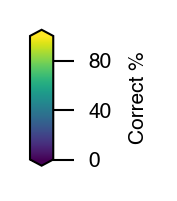

In [30]:
from ALLCools.plot.color import plot_colorbar
from matplotlib.cm import get_cmap

cmap = get_cmap('viridis')
fig, cax = plt.subplots(figsize=(0.1, 0.6), dpi=300)
plot_colorbar(
    cax,
    cmap,
    hue_norm=(0, 100),
    cnorm=None,
    label='Correct %',
    orientation='vertical',
    labelsize=5,
    linewidth=0.5)
fig.savefig('sunburst.colorbar.pdf')